# Model Analysis

## Imports

In [1]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    classification_report, confusion_matrix,
    matthews_corrcoef, cohen_kappa_score
)

## Get data (distances)

In [2]:
DATA = "distances.txt"

# Read data
f = open(DATA, "r")
lines = f.read()
f.close()

# General information
general_match = re.search(
    r"Classes found:\s+(\d+).*?"
    r"Images per class:\s+(\d+).*?"
    r"Total images:\s+(\d+)",
    lines, re.S
)
if not general_match:
    raise ValueError("Invalid General Match lines")

classes, image_per_class, total_images = map(int, general_match.groups())

# Distances
blocks = re.split(r'=== Distances for image with label\s+', lines)[1:]
instance = []
for block in blocks:
    # Header label
    label_match = re.match(r"(\S+)\s+===", block)
    if not label_match:
        raise ValueError("Invalid block label")
        
    label = label_match.group(1)

    # Distances
    distance_match = re.findall(r"-\s+(\S+):\s+([\d.]+)", block, re.S)
    if not distance_match:
        raise ValueError("Invalid block distances")

    distances = sorted(map(lambda x: (x[0], float(x[1])), distance_match), key=lambda x:x[0])
    instance.append((label, dict(distances)))

class_names = list(instance[0][1].keys())

print(f"Obtained information for {total_images} images divided in {classes} classes with {image_per_class} each one")

Obtained information for 16380 images divided in 28 classes with 585 each one


## Get metrics

First, define a function to modularize metric calculation and plotting for each case. It's important to take into account that the idea is consider cases where model returns 1, 2, or 3 possibles classes.

In [3]:
def get_metrics(k):
    y_true, y_pred = [], []
    for label, distances in instance:
        y_true.append(label)
        dst = sorted(distances, key=distances.get)
        correct = False
        for i in range(k):
            if dst[i] == label:
                correct = True
                break
        if correct:
            y_pred.append(label)
        else:
            y_pred.append(dst[0])

    # Get metrics
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Balanced accuracy:", balanced_accuracy_score(y_true, y_pred))
    print("Matthews_corrcoef:", matthews_corrcoef(y_true, y_pred))
    print("Cohen's Kappa:", cohen_kappa_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Classification report
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    
    ## Filter only classes
    df_classes = df_report.iloc[:-3, :3]  # precision, recall, f1-score
    
    df_classes.plot(kind='bar', figsize=(10,6))
    plt.title("Precision, Recall and F1 per Class")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.show()
    
    # Error rate
    error_rate = 1 - df_classes['recall']
    
    plt.figure(figsize=(10,6))
    error_rate.plot(kind='bar', color='red')
    plt.title("Error Rate per Class")
    plt.ylabel("Error Rate")
    plt.ylim(0,1)
    plt.xticks(rotation=45)
    plt.show()

Now, for 1 returned class we achieve 0.824 accuracy (pretty good):

Accuracy: 0.8241758241758241
Balanced accuracy: 0.8241758241758242
Matthews_corrcoef: 0.8177954798752138
Cohen's Kappa: 0.8176638176638177
              precision    recall  f1-score   support

     yaleB11       0.98      0.94      0.96       117
     yaleB12       0.97      0.97      0.97       117
     yaleB13       1.00      0.93      0.96       117
     yaleB15       0.84      0.85      0.84       117
     yaleB16       0.73      0.73      0.73       117
     yaleB17       0.74      0.72      0.73       117
     yaleB18       0.78      0.81      0.79       117
     yaleB19       0.59      0.65      0.62       117
     yaleB20       0.64      0.74      0.69       117
     yaleB21       0.85      0.75      0.80       117
     yaleB22       0.93      0.93      0.93       117
     yaleB23       0.82      0.70      0.76       117
     yaleB24       0.89      0.79      0.84       117
     yaleB25       0.78      0.79      0.79       117
     yaleB26       0.76      0.75      0.76       

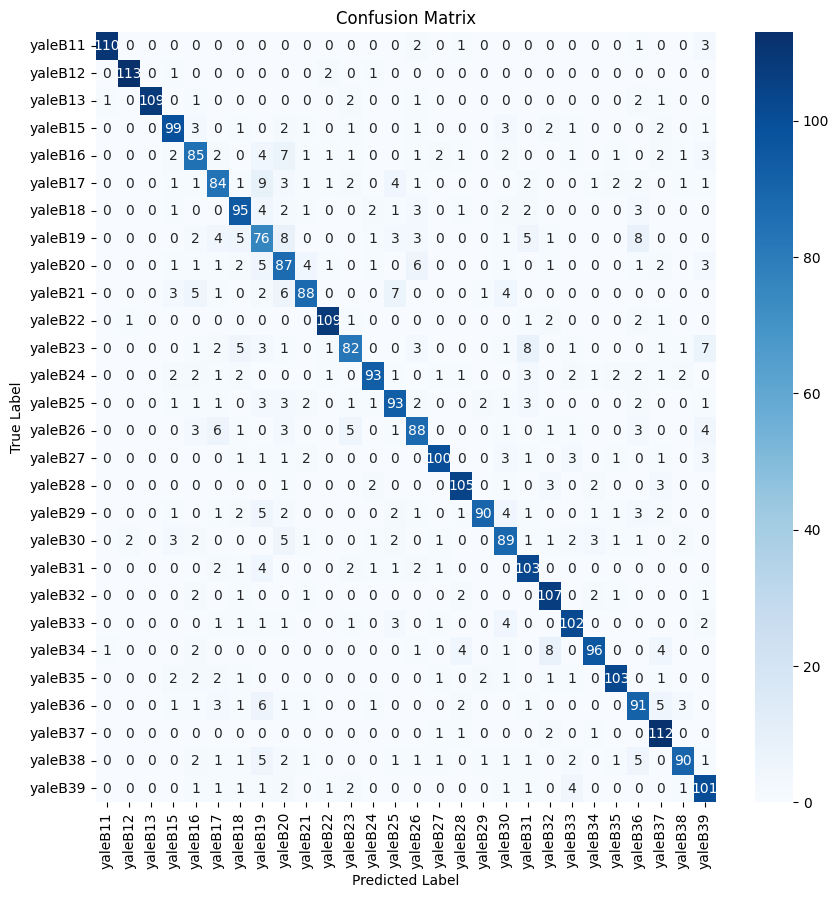

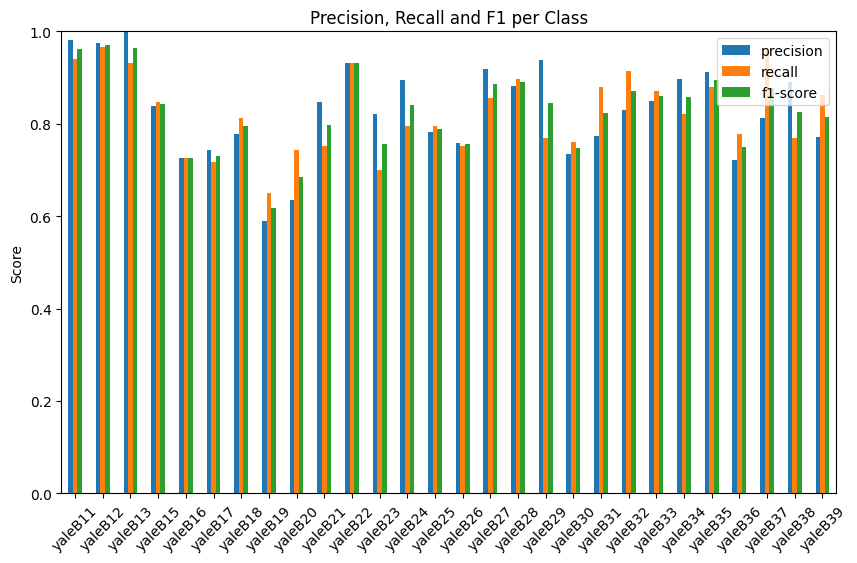

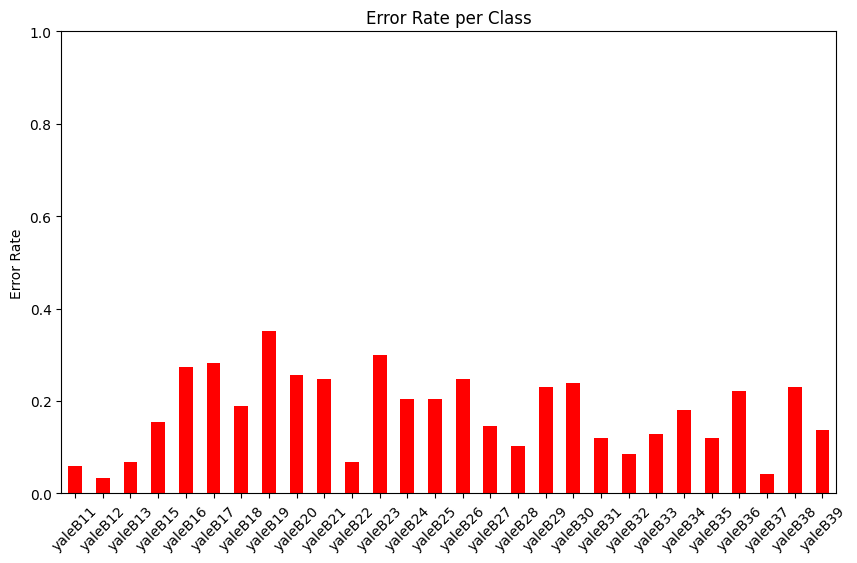

In [4]:
get_metrics(1)

For 2 returned classes we achieve 0.886 accuracy:

Accuracy: 0.8855311355311355
Balanced accuracy: 0.8855311355311356
Matthews_corrcoef: 0.8813773147077086
Cohen's Kappa: 0.8812915479582146
              precision    recall  f1-score   support

     yaleB11       0.99      0.97      0.98       117
     yaleB12       0.98      0.97      0.97       117
     yaleB13       1.00      0.95      0.97       117
     yaleB15       0.87      0.93      0.90       117
     yaleB16       0.84      0.85      0.85       117
     yaleB17       0.82      0.75      0.79       117
     yaleB18       0.87      0.88      0.87       117
     yaleB19       0.70      0.77      0.73       117
     yaleB20       0.78      0.81      0.79       117
     yaleB21       0.90      0.79      0.85       117
     yaleB22       0.94      0.96      0.95       117
     yaleB23       0.89      0.79      0.84       117
     yaleB24       0.93      0.85      0.88       117
     yaleB25       0.82      0.85      0.84       117
     yaleB26       0.88      0.85      0.86       

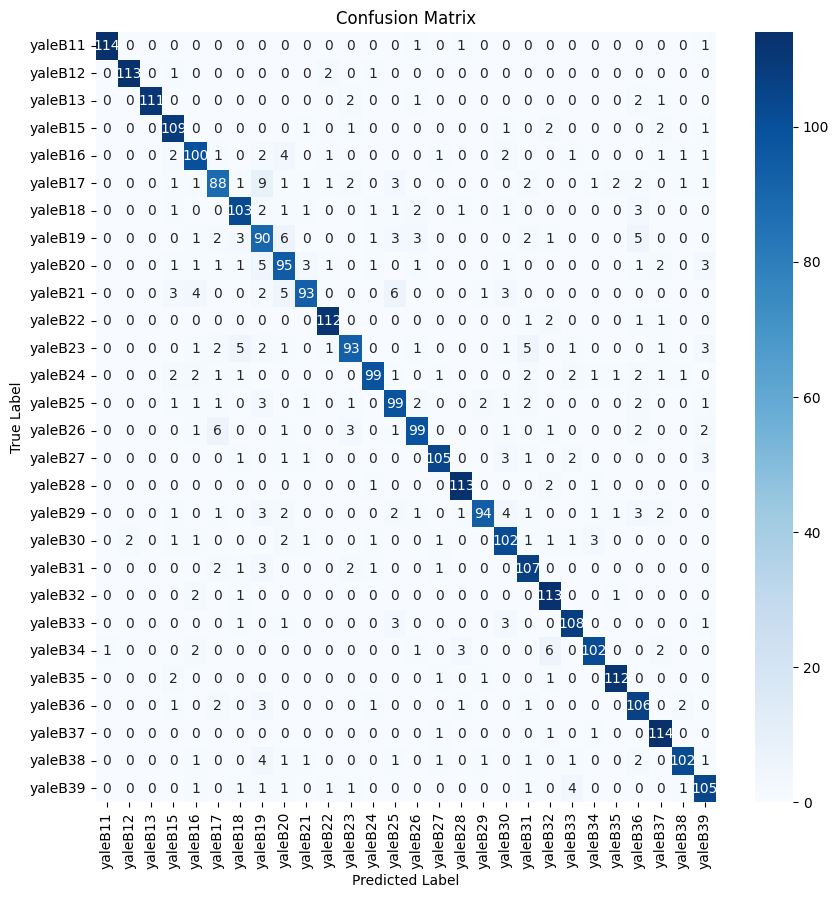

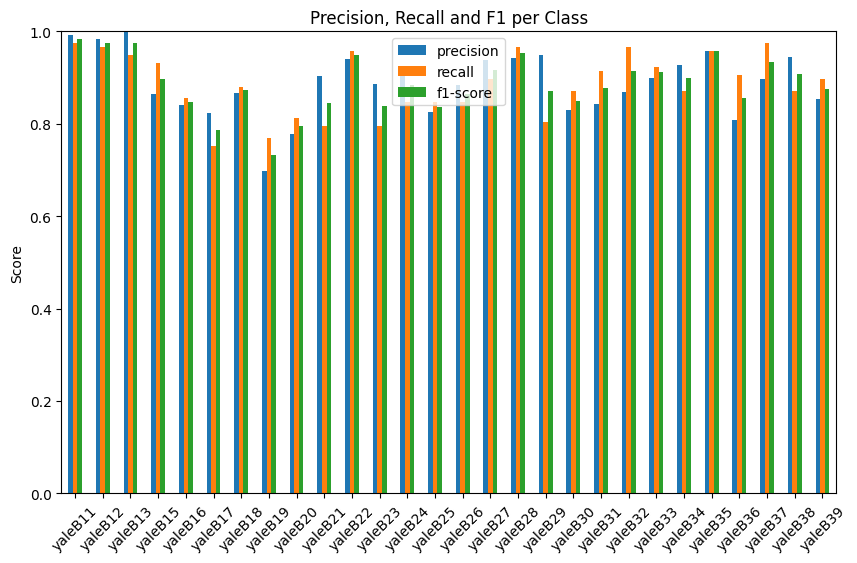

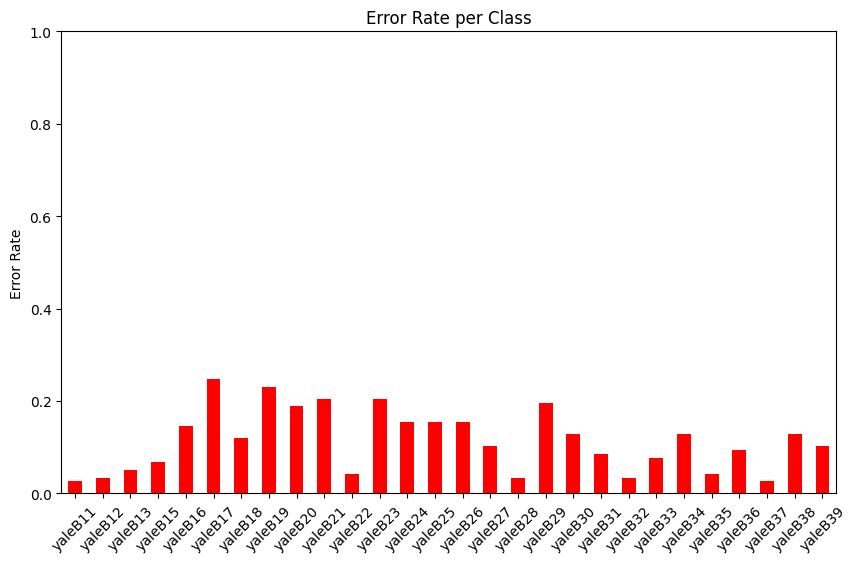

In [5]:
get_metrics(2)

And for 3 returned classes, we achieve 0.912 accuracy:

Accuracy: 0.9117826617826618
Balanced accuracy: 0.9117826617826619
Matthews_corrcoef: 0.9085711917377007
Cohen's Kappa: 0.9085153529597974
              precision    recall  f1-score   support

     yaleB11       0.99      0.99      0.99       117
     yaleB12       0.98      0.97      0.97       117
     yaleB13       1.00      0.96      0.98       117
     yaleB15       0.89      0.94      0.91       117
     yaleB16       0.89      0.89      0.89       117
     yaleB17       0.85      0.79      0.82       117
     yaleB18       0.91      0.89      0.90       117
     yaleB19       0.76      0.82      0.79       117
     yaleB20       0.85      0.89      0.87       117
     yaleB21       0.93      0.85      0.88       117
     yaleB22       0.94      0.96      0.95       117
     yaleB23       0.93      0.87      0.90       117
     yaleB24       0.93      0.85      0.89       117
     yaleB25       0.86      0.87      0.86       117
     yaleB26       0.91      0.89      0.90       

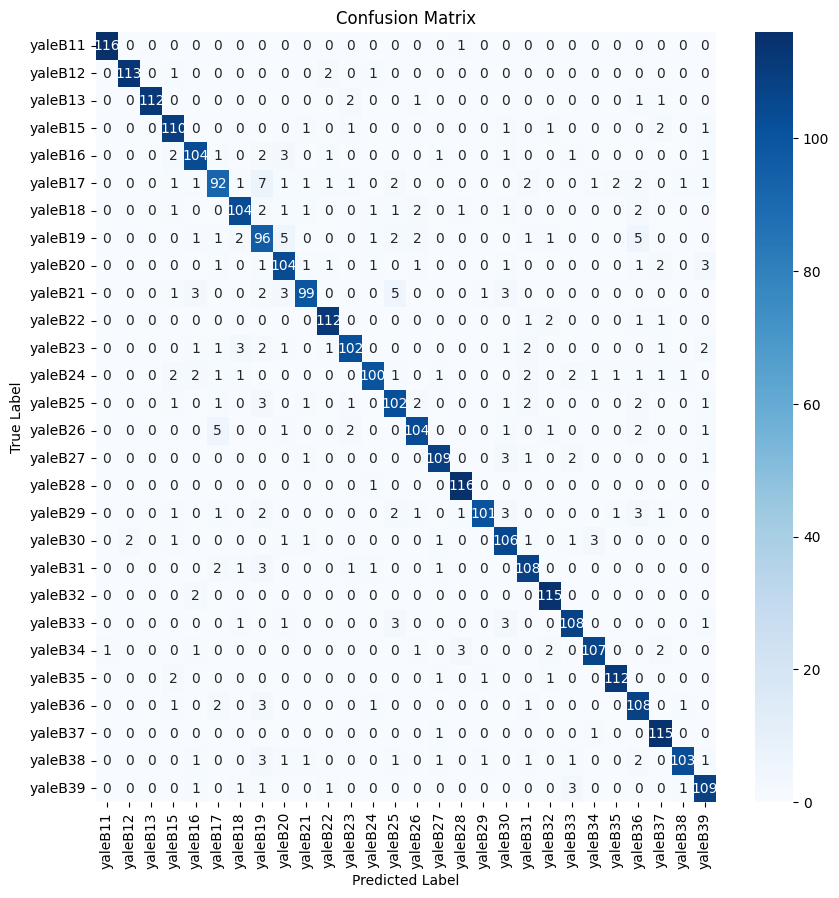

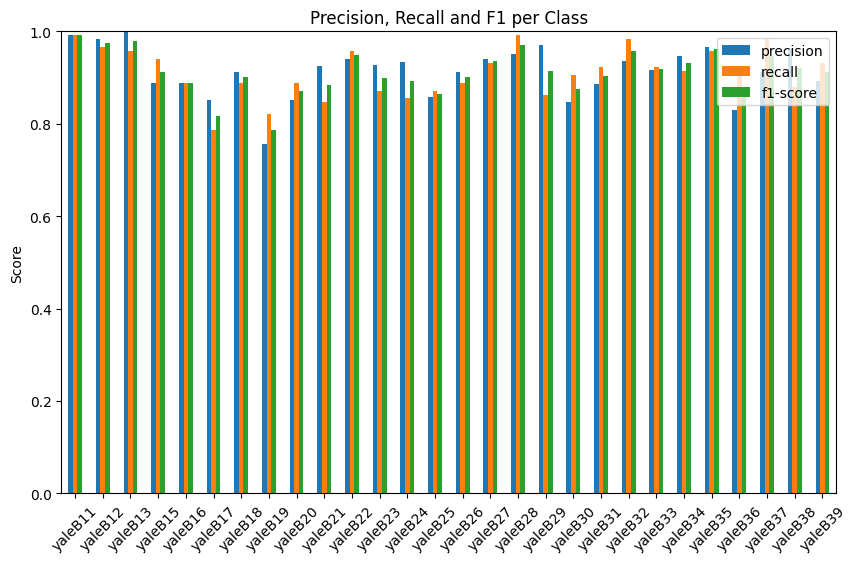

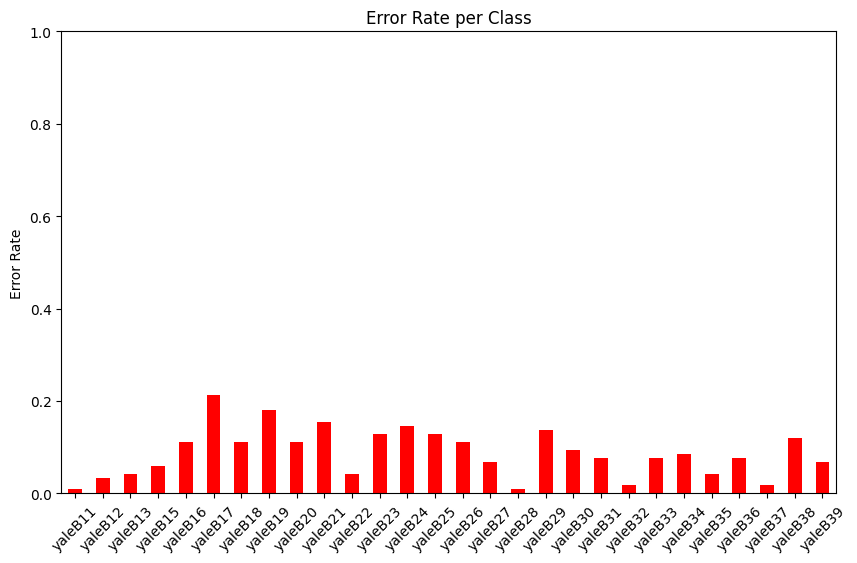

In [6]:
get_metrics(3)

Note: _this results doesn't take into account model thresholds, because validation phase isn't done. The idea for the model, is divide training data into three parts: train, validation and test. Validation part has to be used to calculate best hyperparams $\varepsilon_0, \varepsilon_1$ for our algorithm. This is important because this thresholds are distances (not probabilities or values in specific range. Their range depends of image shape._